In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
"List of Cancer Types in PCAWG Dataset"
cancer_type_list = ['Biliary-AdenoCA',
 'Bladder-TCC',
 'Bone-Benign',
 'Bone-Epith',
 'Bone-Osteosarc',
 'Breast-AdenoCA',
 'Breast-DCIS',
 'Breast-LobularCA',
 'CNS-GBM',
 'CNS-Medullo',
 'CNS-Oligo',
 'CNS-PiloAstro',
 'Cervix-AdenoCA',
 'Cervix-SCC',
 'ColoRect-AdenoCA',
 'Eso-AdenoCA',
 'Head-SCC',
 'Kidney-ChRCC',
 'Kidney-RCC',
 'Liver-HCC',
 'Lung-AdenoCA',
 'Lung-SCC',
 'Lymph-BNHL',
 'Lymph-CLL',
 'Myeloid-AML',
 'Myeloid-MDS',
 'Myeloid-MPN',
 'Ovary-AdenoCA',
 'Panc-AdenoCA',
 'Panc-Endocrine',
 'Prost-AdenoCA',
 'Skin-Melanoma',
 'SoftTissue-Leiomyo',
 'SoftTissue-Liposarc',
 'Stomach-AdenoCA',
 'Thy-AdenoCA',
 'Uterus-AdenoCA']


In [3]:
def abs_path(target_name, directory_level): 
    """
Returns absolute file path of target name in working directory.

Arguments:
    target_name (str): Name of file or folder to find.
    directory_level (str): Level of os search, either File or Folder.   
    """
    #Find the relative working directory of the script
    wk_dir = os.path.dirname(os.path.realpath('__file__'))
    
    if directory_level == "File":
        #Absolute file path
        for root, dirs, files in os.walk(wk_dir):
            for name in files:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
             
    #Absolute file path
    if directory_level == "Directory":
        for root, dirs, files in os.walk(wk_dir):
            for name in dirs:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
    
    return target_path

In [4]:
def ref_data(input_name, num=False, prop=False):
    """
Reads in reference datasets from PCAWG studies.

Arguments:
    input_name (str): Name of csv file 
    num (bool): Set true to return dataframe of PCAWG SigProfiler Signatures in Samples 
    prop (bool): Set true to return dataframe of SigProfiler Signature Contributions
    
Note: Must set only one of num or prop arguments to True. 
    """
    if prop == num:
        raise ValueError("Please set only one argument between the arguments num and prop to True.")
        
    if num is True:
        
        num_file_path = abs_path(input_name, "File")
        num_data = pd.read_csv(num_file_path)
        num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
        num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)
        
        return num_data

    if prop is True:
            
        prop_file_path = abs_path(input_name, input_type )
        prop_data = pd.read_csv(prop_file_path)
        
        return prop_data
    

In [5]:
cd /Users/davidchen/Documents/GitHub/SomaticSiMu

/Users/davidchen/Documents/GitHub/SomaticSiMu


In [6]:
"""
SBS input reference files
"""
sbs_num_file_path = abs_path("PCAWG_sigProfiler_SBS_signatures_in_samples.csv","File")
sbs_num_data = pd.read_csv(sbs_num_file_path)
sbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
sbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

sbs_prop_file_path = abs_path("sigProfiler_SBS_signatures.csv","File")
sbs_prop_data = pd.read_csv(sbs_prop_file_path)
  

"""
DBS input reference files
"""
dbs_num_file_path = abs_path("PCAWG_sigProfiler_DBS_signatures_in_samples.csv","File")
dbs_num_data = pd.read_csv(dbs_num_file_path)
dbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
dbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

dbs_prop_file_path = abs_path("sigProfiler_DBS_signatures.csv","File")
dbs_prop_data = pd.read_csv(dbs_prop_file_path)


"""
Insertion/Deletion input reference files
"""
id_num_file_path = abs_path("PCAWG_SigProfiler_ID_signatures_in_samples.csv","File")
id_num_data = pd.read_csv(id_num_file_path)
id_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
id_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

id_prop_file_path = abs_path("sigProfiler_ID_signatures.csv","File")
id_prop_data = pd.read_csv(id_prop_file_path)

"""
Expected Frequency Absolute Folder Paths for SBS, DBS and ID
"""
sbs_freq_folder_path = abs_path("SBS_Expected_Frequency", "Directory")
dbs_freq_folder_path = abs_path("DBS_Expected_Frequency", "Directory")
id_freq_folder_path = abs_path("ID_Expected_Frequency", "Directory")

In [7]:
def sig_proportion(cancer_type, num_data, std_outlier):
    """
Find the proportions of different combinations of signatures among all samples
Output proportion of samples with each combination of signatures. 

Arguments:
    cancer_type (str): Cancer type 
    num_data (dataframe): Signature data
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    cols = n_mutation_df.columns
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    #print("Removed the following outliers from the signature combination probability matrix:" + str(set_outlier))

    #Drop outlier sequences 
    n_mutation_df.drop(set_outlier,inplace=True)
    
    #Dataframe of the proportion of a set of signatures contribution out of all possible combinations
    bt=n_mutation_df.apply(lambda x: x > 0)
    
    sig_prop = ( bt.apply( lambda x: (cols[x.values]) , axis=1).value_counts() ) / len(bt)
    
    return sig_prop

In [8]:
def outlier_detection(cancer_type, num_data, std_outlier):
    """
Identifies outliers in the dataframe, returns list of outliers

Arguments;
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    std_outlier: Parameter to exclude outliers by degrees of standard deviation 
    """ 
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    return set_outlier

In [9]:
def mut_mean(cancer_type, num_data, freq_folder_path, mut_type, std_outlier):
    """
Output average number of 96 type mutations among all samples for specified cancer type.

Arguments:
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    freq_folder_path (str): Folder with expected mutation frequencies for each sample
    mut_type (str): "SBS", "DBS", "ID"
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    if mut_type == "SBS":
         
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("SBS_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(sbs_freq_folder_path) + "/SBS_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        

        #print("Removed " + str(len(file_paths)-len(filtered_file_paths)) + " outliers from the average mutation frequency matrix")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0])
        mean_df = og_df.loc[:, 'SBS1':]
    
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'SBS1':]
            mean_df += slice_read_df
            
        df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:, 'Type': 'SubType']
        average_freq_df = pd.concat([mut_subtypes, df_averages], axis=1)
        
        return average_freq_df
  
    if mut_type == "DBS":
        
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("DBS_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(dbs_freq_folder_path)+ "/DBS_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        
        #print("Dropped " + str(len(file_paths)-len(filtered_file_paths)) + " outliers!")
        #print("")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0], index_col=0)
        mean_df = og_df.loc[:, 'DBS1':]
        
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'DBS1':]
            mean_df += slice_read_df
            
        dbs_df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:,'Mutation Type'].to_frame() 
        average_freq_df = pd.concat([mut_subtypes, dbs_df_averages], axis=1)
        
        return average_freq_df

    if mut_type == "ID":
        
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("ID_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(id_freq_folder_path) + "/ID_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        
        #print("Dropped " + str(len(file_paths)-len(filtered_file_paths)) + " outliers!")
        #print("")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0], index_col=0)
        mean_df = og_df.loc[:, 'ID1':]
        
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'ID1':]
            mean_df += slice_read_df
            
        id_df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:,'Mutation Type':'ID_type']
        average_freq_df = pd.concat([mut_subtypes, id_df_averages], axis=1)
        
        return average_freq_df
  
    if mut_type not in ["SBS", "DBS", "ID"]:
        raise ValueError("It looks like you did not input an appropriate mut_type argument (SBS, DBS, ID)")

    else: 
        print("Completed calculations of average " + str(mut_type) + "mutation expected frequency for " + str(cancer_type))

 

# SBS Whole Genome Mutation Burden

In [10]:
sbs_num_data['Total'] = sbs_num_data.iloc[:,3:].sum(axis=1)

In [11]:
sbs_mut_burden = sbs_num_data[['Cancer Types', 'Total']].copy()

In [12]:
sbs_mut_burden.reset_index(inplace=True, drop=True)

In [13]:
sbs_order = sbs_mut_burden.groupby("Cancer Types").describe()
sbs_order = list(sbs_order.sort_values(('Total',  '50%')).index)

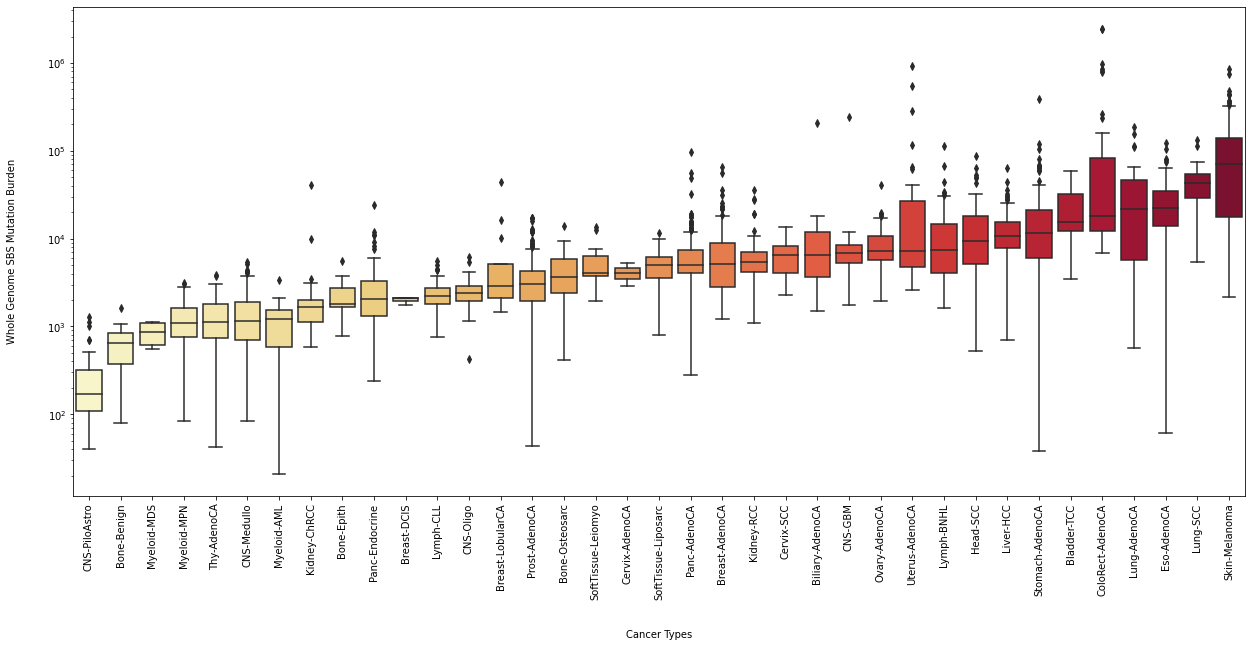

In [14]:
fig, ax= plt.subplots(figsize=(21, 9))
ax.set_yscale('log')
ax = sns.boxplot(x="Cancer Types", y="Total", data=sbs_mut_burden, order=sbs_order, orient="v", palette = "YlOrRd")
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    fontweight='light',
    fontsize='medium')
ax.set(xlabel = "Cancer Types", ylabel = "Whole Genome SBS Mutation Burden")
ax.xaxis.labelpad= 30
ax.yaxis.labelpad= 30

In [15]:
filtered_list = ['Bone-Benign',
'Bone-Epith',
'Bone-Osteosarc',
'Breast-AdenoCA',
'Breast-DCIS',
'Breast-LobularCA',
'CNS-GBM',
'CNS-Medullo',
'CNS-Oligo',
'CNS-PiloAstro',
'Myeloid-AML',
'Myeloid-MDS',
'Myeloid-MPN']

In [16]:
filtered_sbs_mut_burden = sbs_mut_burden[sbs_mut_burden['Cancer Types'].isin(filtered_list)].reset_index()
filtered_sbs_order = filtered_sbs_mut_burden.groupby("Cancer Types").describe()
filtered_sbs_order = list(filtered_sbs_order.sort_values(('Total',  '50%')).index)

In [17]:
len(filtered_sbs_mut_burden)

644

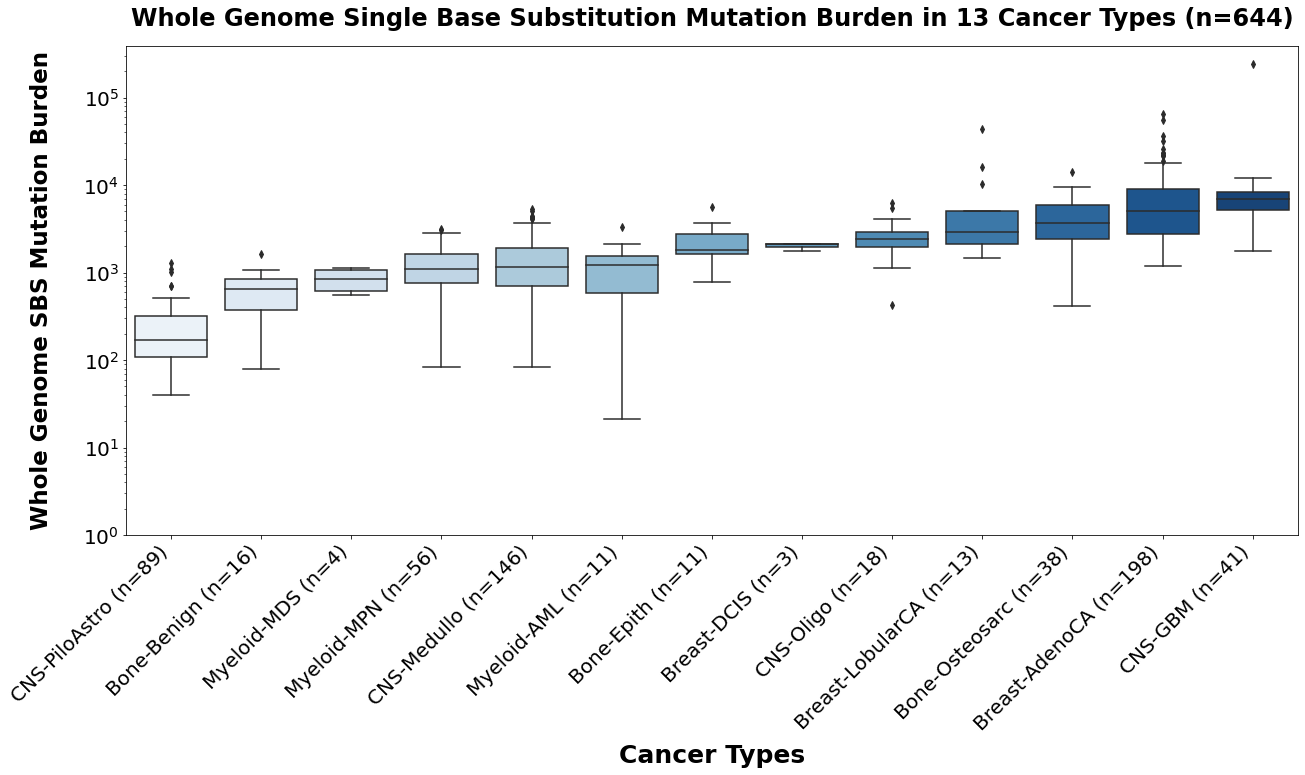

In [21]:
fig, ax= plt.subplots(figsize=(21, 9))
ax.set_yscale('log')
ax = sns.boxplot(x="Cancer Types", y="Total", data=filtered_sbs_mut_burden, order=filtered_sbs_order, orient="v", palette = "Blues")




labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = []
for label in labels:
    new_labels.append(label + ' (n=' + str(len(filtered_sbs_mut_burden[filtered_sbs_mut_burden['Cancer Types'] == label])) + ')')

ax.set_xticklabels(
    new_labels, 
    rotation=45, 
    size=50,
    fontweight='light',
    fontsize='medium'
, horizontalalignment="right"
)


ax.set_xlabel("Cancer Types",fontsize=25, labelpad=10, weight="bold")
ax.set_ylabel("Whole Genome SBS Mutation Burden",fontsize=23, labelpad=10, weight="bold")

ax.set_ylim(1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Whole Genome Single Base Substitution Mutation Burden in 13 Cancer Types (n=644)', size=24, weight="bold", pad=20)
ax.xaxis.labelpad= 10
ax.yaxis.labelpad= 30


# DBS Whole Genome Mutation Burden

In [28]:
dbs_num_data['Total'] = dbs_num_data.iloc[:,3:].sum(axis=1)
dbs_mut_burden = dbs_num_data[['Cancer Types', 'Total']].copy()
dbs_mut_burden.reset_index(inplace=True, drop=True)
dbs_order = dbs_mut_burden.groupby("Cancer Types").describe()
dbs_order = list(dbs_order.sort_values(('Total',  '50%')).index)

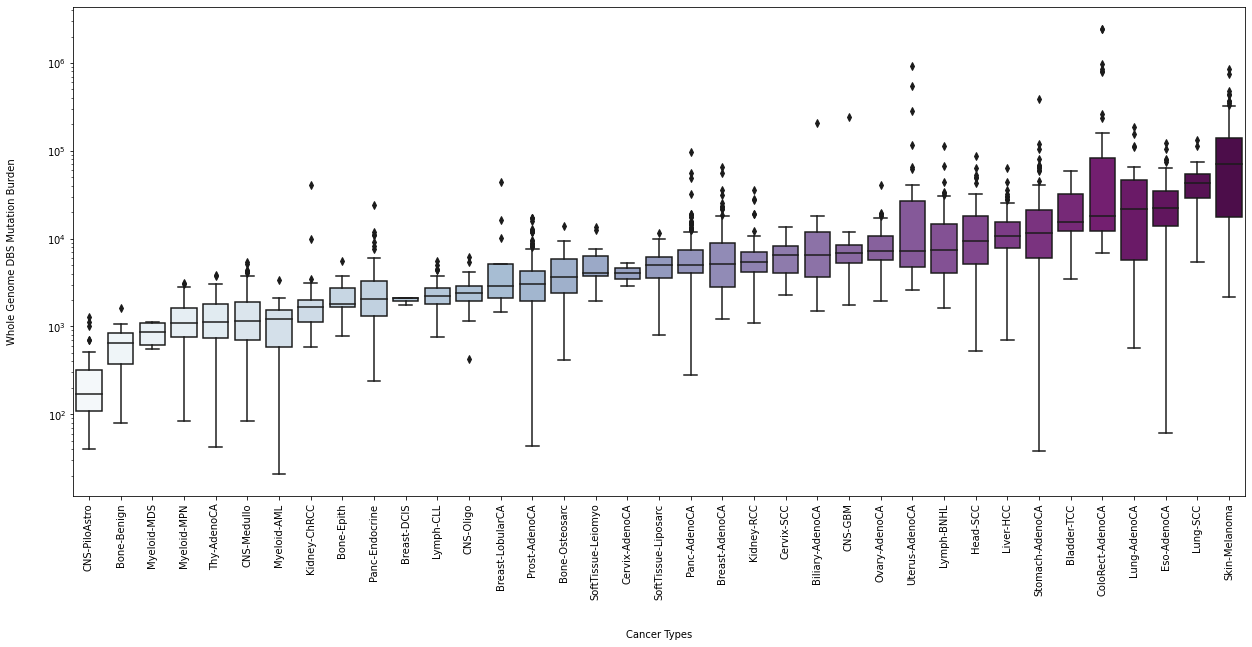

In [29]:
fig, ax= plt.subplots(figsize=(21, 9))
ax.set_yscale('log')
ax = sns.boxplot(x="Cancer Types", y="Total", data=sbs_mut_burden, order=sbs_order, orient="v", palette = "BuPu")
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    fontweight='light',
    fontsize='medium')
ax.set(xlabel = "Cancer Types", ylabel = "Whole Genome DBS Mutation Burden")
ax.xaxis.labelpad= 30
ax.yaxis.labelpad= 30

In [30]:
filtered_dbs_mut_burden = dbs_mut_burden[dbs_mut_burden['Cancer Types'].isin(filtered_list)].reset_index()
filtered_dbs_order = filtered_dbs_mut_burden.groupby("Cancer Types").describe()
filtered_dbs_order = list(filtered_dbs_order.sort_values(('Total',  '50%')).index)

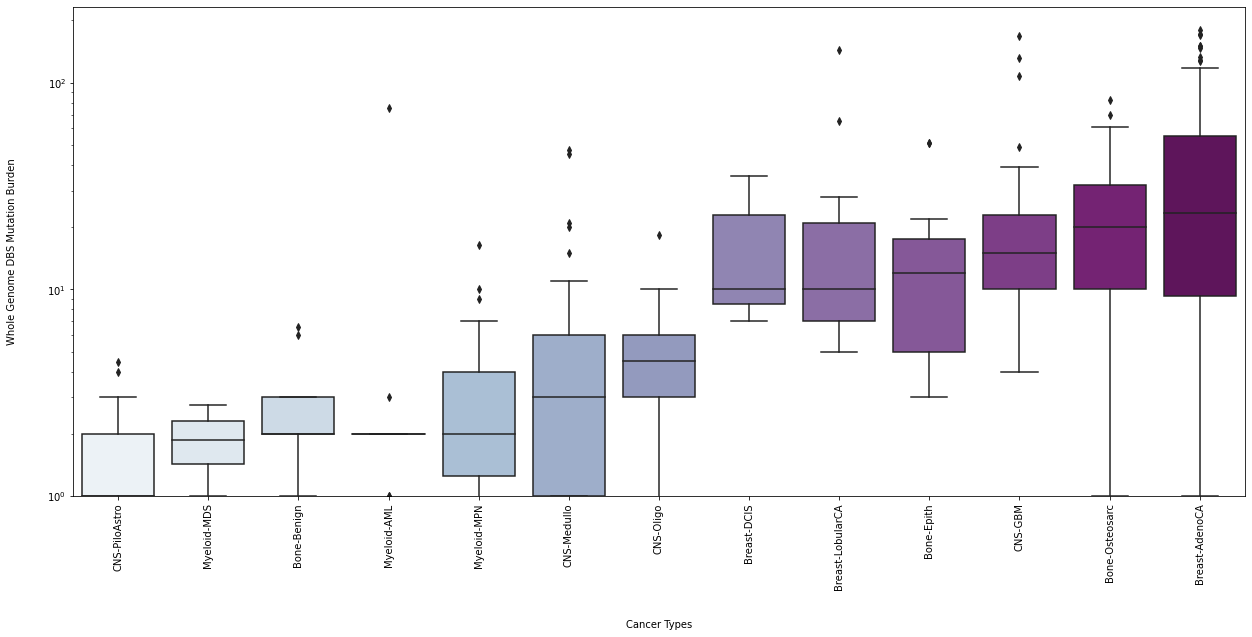

In [34]:
fig, ax= plt.subplots(figsize=(21, 9))
ax.set_yscale('log')
ax = sns.boxplot(x="Cancer Types", y="Total", data=filtered_dbs_mut_burden, order=filtered_dbs_order, orient="v", palette = "BuPu")
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    fontweight='light',
    fontsize='medium')
ax.set(xlabel = "Cancer Types", ylabel = "Whole Genome DBS Mutation Burden")
ax.set_ylim(1)
ax.xaxis.labelpad= 30
ax.yaxis.labelpad= 30

# Indel Whole Genome Mutation Burden

In [36]:
id_num_data['Total'] = id_num_data.iloc[:,3:].sum(axis=1)
id_mut_burden = id_num_data[['Cancer Types', 'Total']].copy()
id_mut_burden.reset_index(inplace=True, drop=True)
id_order = id_mut_burden.groupby("Cancer Types").describe()
id_order = list(id_order.sort_values(('Total',  '50%')).index)

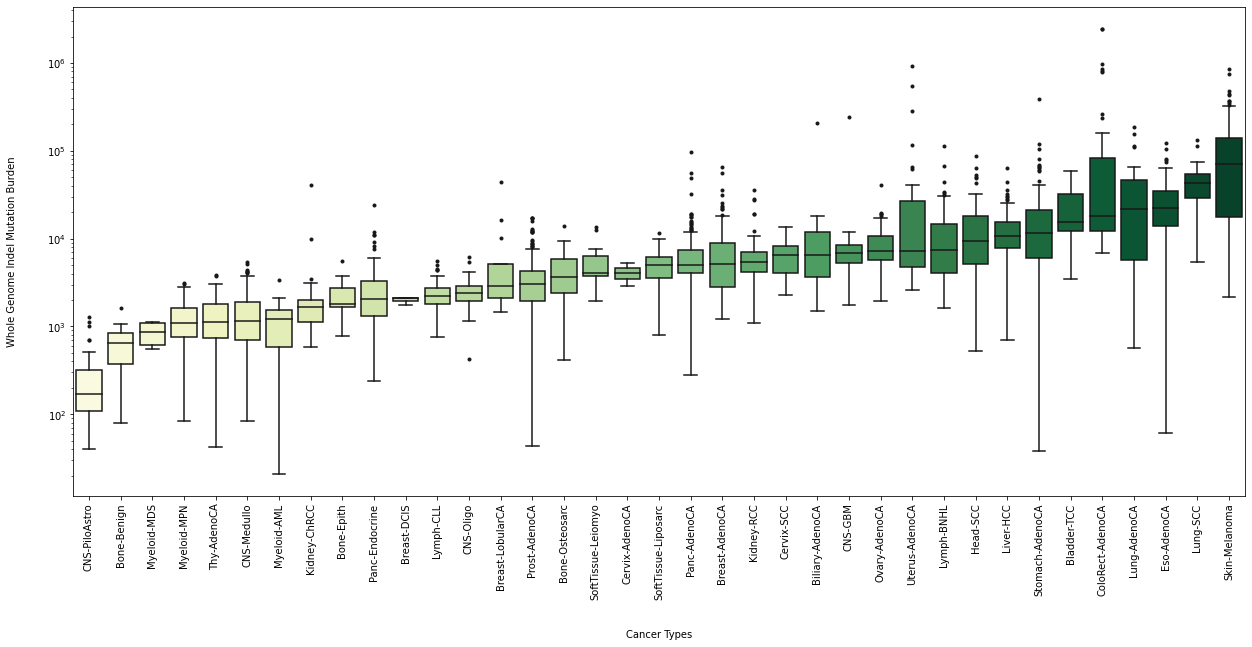

In [37]:
fig, ax= plt.subplots(figsize=(21, 9))
ax.set_yscale('log')
ax = sns.boxplot(x="Cancer Types", y="Total", data=sbs_mut_burden, order=sbs_order, orient="v", palette = "YlGn", flierprops=dict(marker='o', markersize=3))
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    fontweight='light',
    fontsize='medium')
ax.set(xlabel = "Cancer Types", ylabel = "Whole Genome Indel Mutation Burden")
ax.xaxis.labelpad= 30
ax.yaxis.labelpad= 30

In [38]:
filtered_id_mut_burden = id_mut_burden[id_mut_burden['Cancer Types'].isin(filtered_list)].reset_index()
filtered_id_order = filtered_id_mut_burden.groupby("Cancer Types").describe()
filtered_id_order = list(filtered_id_order.sort_values(('Total',  '50%')).index)

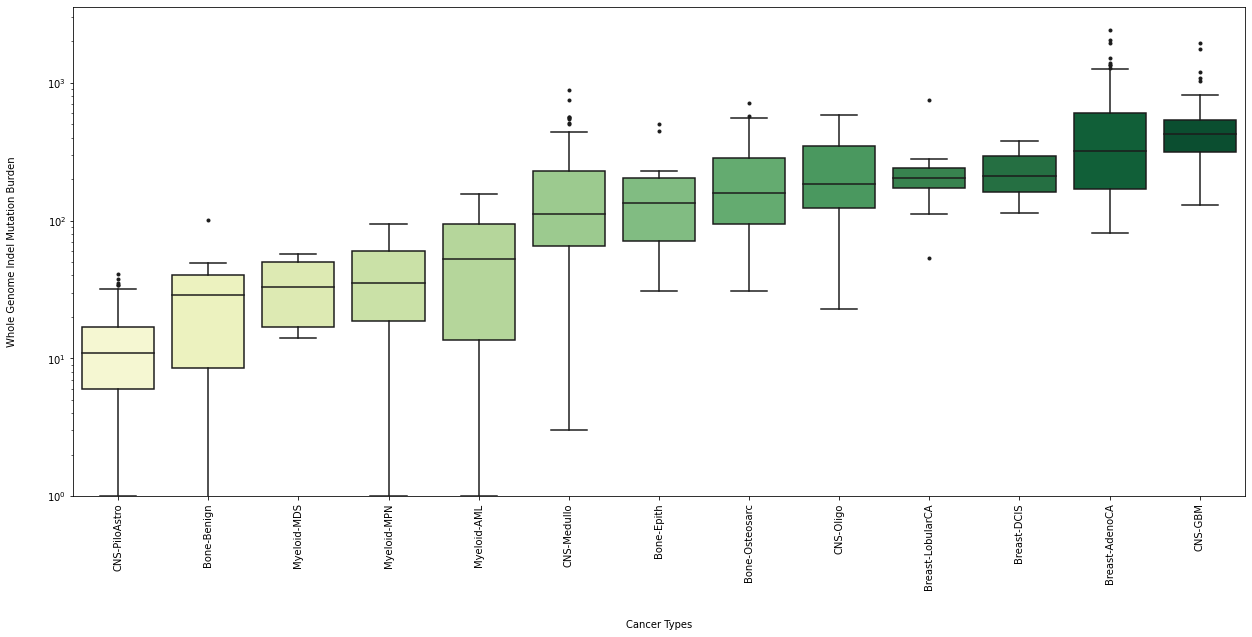

In [41]:
fig, ax= plt.subplots(figsize=(21, 9))
ax.set_yscale('log')
ax = sns.boxplot(x="Cancer Types", y="Total", data=filtered_id_mut_burden, order=filtered_id_order, orient="v", palette = "YlGn", flierprops=dict(marker='o', markersize=3))
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    fontweight='light',
    fontsize='medium')
ax.set(xlabel = "Cancer Types", ylabel = "Whole Genome Indel Mutation Burden")
ax.set_ylim(1)
ax.xaxis.labelpad= 30
ax.yaxis.labelpad= 30